In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz

from IPython.display import Image, display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

## 8.3.1 Fitting Classification Trees

In [2]:
carseats = pd.read_csv('../data/carseats.csv')
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [3]:
# check if there is any missing value
carseats.isna().any()

Sales          False
CompPrice      False
Income         False
Advertising    False
Population     False
Price          False
ShelveLoc      False
Age            False
Education      False
Urban          False
US             False
dtype: bool

In [4]:
carseats['High'] = carseats['Sales'] > 8
carseats = pd.get_dummies(carseats, columns=['ShelveLoc', 'Urban', 'US'])
carseats.drop(['ShelveLoc_Bad', 'Urban_No', 'US_No'], axis=1, inplace=True)
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,High,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,9.50,138,73,11,276,120,42,17,True,0,0,1,1
1,11.22,111,48,16,260,83,65,10,True,1,0,1,1
2,10.06,113,35,10,269,80,59,12,True,0,1,1,1
3,7.40,117,100,4,466,97,55,14,False,0,1,1,1
4,4.15,141,64,3,340,128,38,13,False,0,0,1,0


In [5]:
from sklearn import tree

X = carseats.drop(['High', 'Sales'], axis=1)
y = carseats.High

clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', random_state=0, min_samples_split=20)
tree_classifier = clf.fit(X, y.values.reshape(-1, 1))

In [6]:
# Feature importances 
pd.DataFrame(tree_classifier.feature_importances_, index=X.columns, columns=['Importance'])

,Importance
CompPrice,0.109957
Income,0.074141
Advertising,0.088996
Population,0.034942
Price,0.301531
Age,0.095710
Education,0.004645
ShelveLoc_Good,0.228331
ShelveLoc_Medium,0.052739
Urban_Yes,0.000000


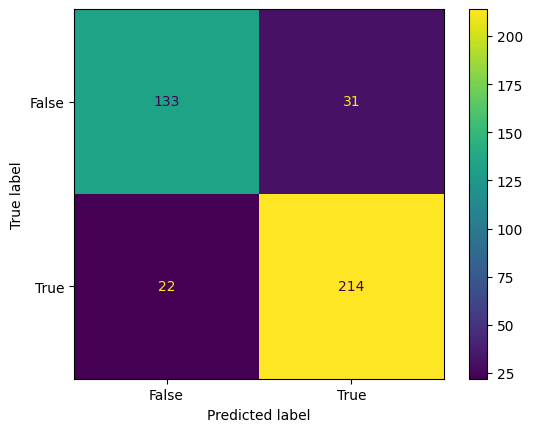

In [7]:
# Confusion Matrix to display classification results
conf_mat = confusion_matrix(y, tree_classifier.predict(X), labels=[True, False])
disp = ConfusionMatrixDisplay(conf_mat, display_labels=tree_classifier.classes_)
disp.plot()

In [8]:
# Training error (Classification error)
print('Training Error: ', (conf_mat[0, 1] + conf_mat[1,0]) / conf_mat.sum())

Training Error:  0.1325


In [9]:
# Number terminal nodes
print('Number of terminal nodes: ', tree_classifier.get_n_leaves())

Number of terminal nodes:  27


In [ ]:
# Need to apply this method in order to fit the graphviz output into jupyter notebook

dot_data = tree.export_graphviz(tree_classifier, out_file='tree.dot', feature_names=X.columns,
                               class_names=['True', 'False'], filled=True,
                               rounded=True, special_characters=True)
with open('tree.dot') as f:
    dot_graph = f.read()

graph = graphviz.Source(dot_graph, format='png', engine='dot')
Image(graph.render())

In order to properly evaluate the performance of a classification tree on these data, we must estimate the test error rather than simply computing the training error.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

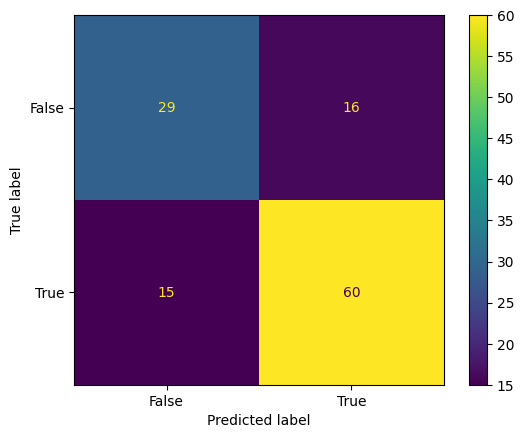

In [12]:
tree_ = clf.fit(X_train, y_train.values.reshape(-1, 1))
pred = tree_.predict(X_test)

conf_mat = confusion_matrix(y_test, pred, labels=[True, False])
disp = ConfusionMatrixDisplay(conf_mat, display_labels=tree_classifier.classes_)
disp.plot()

In [13]:
# Test error (Classification error)
print('Test Set Error: ', (conf_mat[0, 1] + conf_mat[1,0]) / conf_mat.sum())

Test Set Error:  0.25833333333333336


### Pruning

In [14]:
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

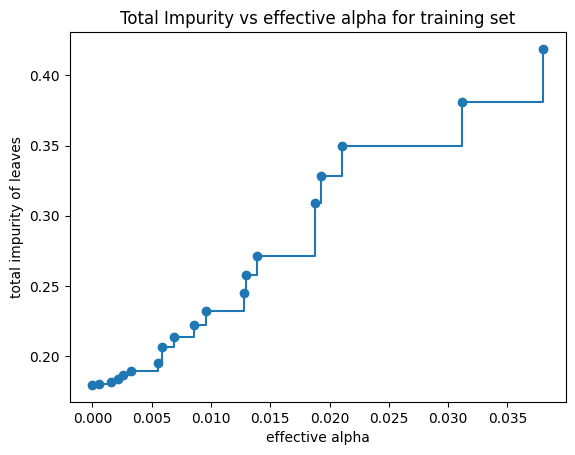

In [15]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle='steps-post')
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

The last value in `ccp_alphas` is the alpha value that prunes the whole tree, leaving the tree, `clfs[-1]`, with one node.

In [16]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=2, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

We remove the last element in `clfs` and `ccp_alphas`, because it is the trivial tree with only one node

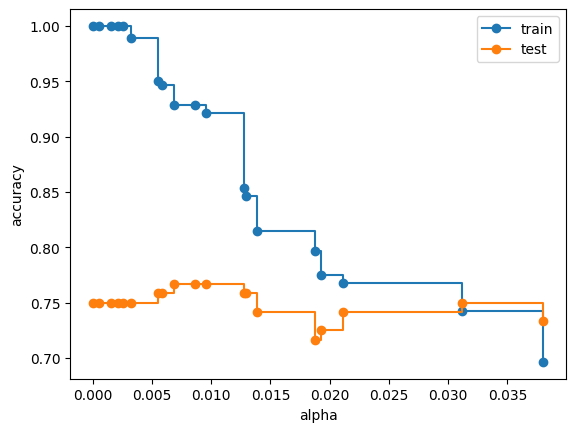

In [17]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle='steps-post')
ax.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle='steps-post')
ax.legend()
plt.show()

In [18]:
# The optimal value of alpha that maximize the test set accuracy
opt_alpha = ccp_alphas[np.argmax(test_scores)]
opt_alpha

0.006907894736842106

In [19]:
pruned_tree = tree.DecisionTreeClassifier(random_state=2, ccp_alpha=opt_alpha)
tree_classifier2 = pruned_tree.fit(X_train, y_train)

In [20]:
# Number terminal nodes
print('Number of terminal nodes: ', tree_classifier2.get_n_leaves())

Number of terminal nodes:  21


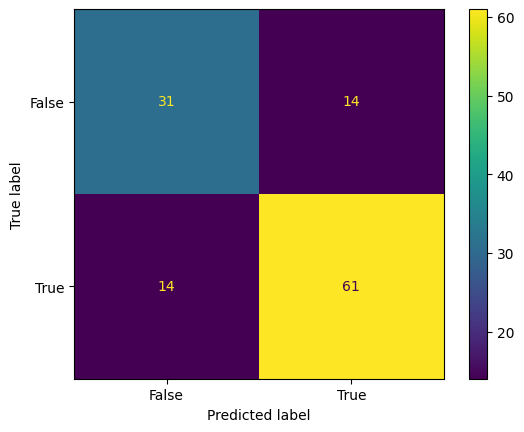

In [21]:
# Confusion Matrix to display classification results
conf_mat = confusion_matrix(y_test, tree_classifier2.predict(X_test), labels=[True, False])
disp = ConfusionMatrixDisplay(conf_mat, display_labels=tree_classifier.classes_)
disp.plot()

In [22]:
# Test error (Classification error)
print('Test Set Error: ', (conf_mat[0, 1] + conf_mat[1,0]) / conf_mat.sum())

Test Set Error:  0.23333333333333334


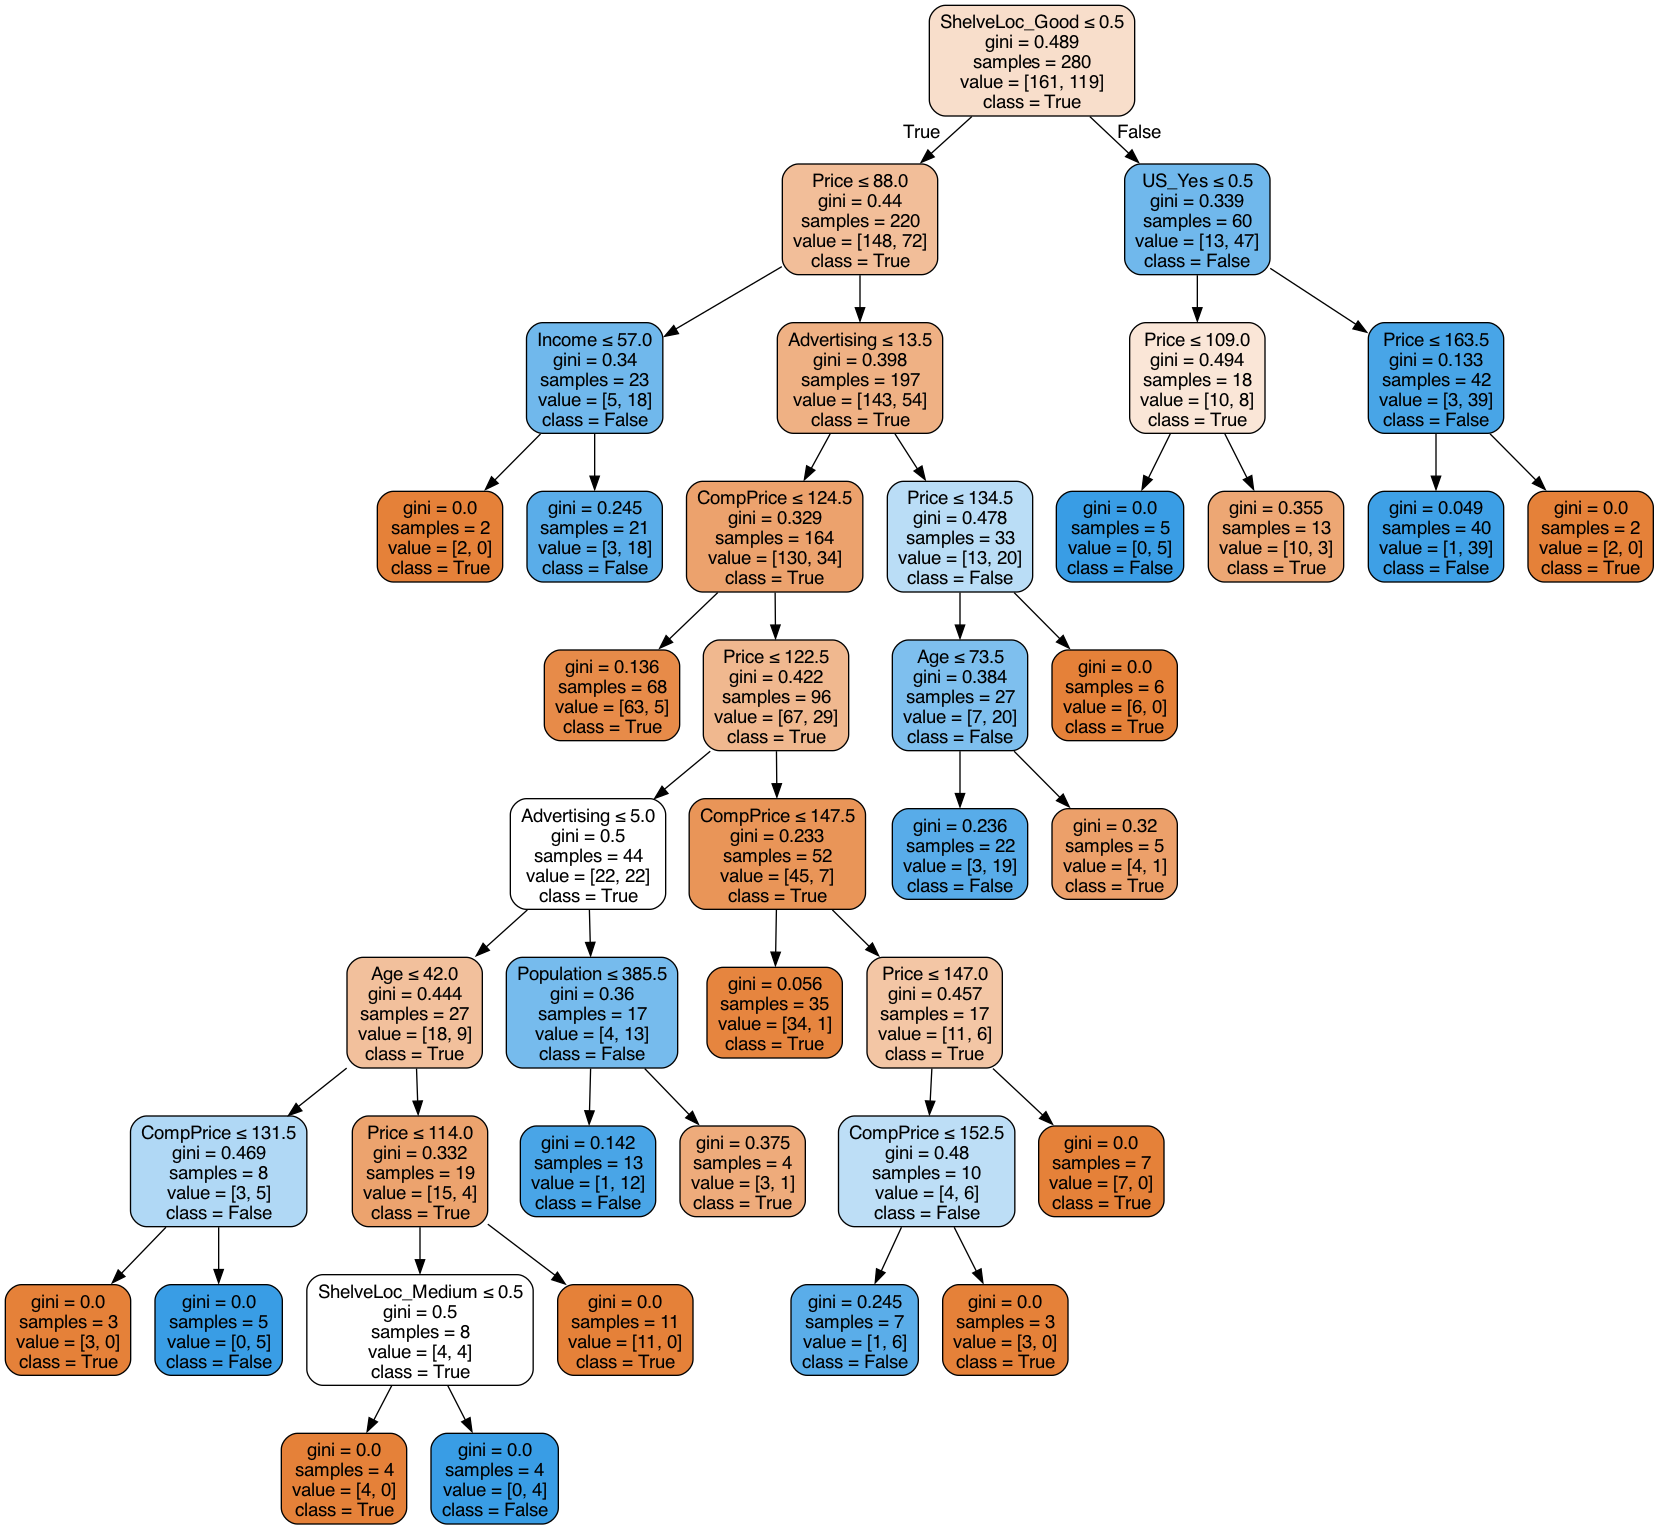

In [23]:
dot_data = tree.export_graphviz(tree_classifier2, out_file='tree2.dot', feature_names=X.columns,
                               class_names=['True', 'False'], filled=True,
                               rounded=True, special_characters=True)
with open('tree2.dot') as f:
    dot_graph = f.read()

graph = graphviz.Source(dot_graph, format='png', engine='dot')
Image(graph.render())

## 8.3.2 Fitting Regression Trees

In [24]:
boston = pd.read_csv('../data/boston.csv')
boston.drop(boston.columns[0], axis=1, inplace=True)
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [25]:
X = boston.drop(['medv'], axis=1)
y = boston.medv

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [26]:
tree_reg = tree.DecisionTreeRegressor(criterion='squared_error', splitter='best',
                                      min_samples_split=20, random_state=1)
tree_reg_fit = tree_reg.fit(X_train, y_train)

In [27]:
# Feature importances 
pd.DataFrame(tree_reg_fit.feature_importances_, index=X.columns, columns=['Importance'])

,Importance
crim,0.018133
zn,0.000000
indus,0.000649
chas,0.000000
nox,0.025852
rm,0.265242
age,0.002333
dis,0.084681
rad,0.000000
tax,0.002207


In [28]:
print('Training Error: ', mean_squared_error(y_train, tree_reg_fit.predict(X_train)))

Training Error:  6.877114501064155


In [29]:
print('Test Error: ', mean_squared_error(y_test, tree_reg_fit.predict(X_test)))

Test Error:  15.133735930237746


Text(0, 0.5, 'Real Values')

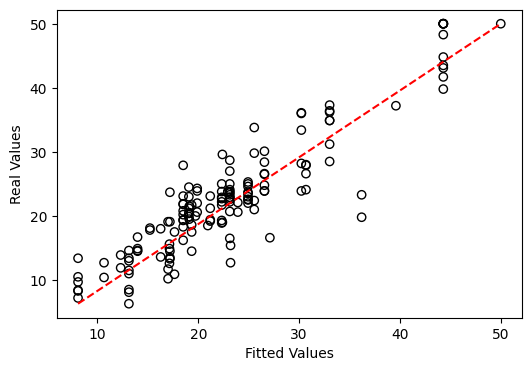

In [30]:
pred = tree_reg_fit.predict(X_test)

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(pred, y_test, facecolor='None', edgecolor='k')
ax.plot([min(pred), max(pred)], [min(y_test), max(y_test)], linestyle='dashed', color='r')

ax.set_xlabel('Fitted Values')
ax.set_ylabel('Real Values')

In [31]:
np.mean(((y_test-pred)**2))

15.133735930237746

## 8.3.3 Bagging and Random Forests

### Bagging

In [32]:
X = boston.drop(['medv'], axis=1)
y = boston.medv

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [33]:
from sklearn.ensemble import BaggingRegressor

bagger = BaggingRegressor(n_estimators=500, max_features=X_train.shape[1],
                        bootstrap=True, oob_score=True, random_state=1)

bagger_est = bagger.fit(X_train, y_train)

In [34]:
# number of features seen during fit
bagger_est.n_features_in_

12

In [35]:
# Score of the training dataset obtained using an out-of-bag estimate
bagger_est.oob_score_

0.8386076726907459

In [36]:
err = np.mean((y_train - bagger_est.predict(X_train))**2)
print(f'Training error: {err}')

Training error: 1.6345552398679732


In [37]:
err = np.mean((y_test - bagger_est.predict(X_test))**2)
print(f'Test set error: {err}')

Test set error: 11.271431966108395


Text(0, 0.5, 'Real Values')

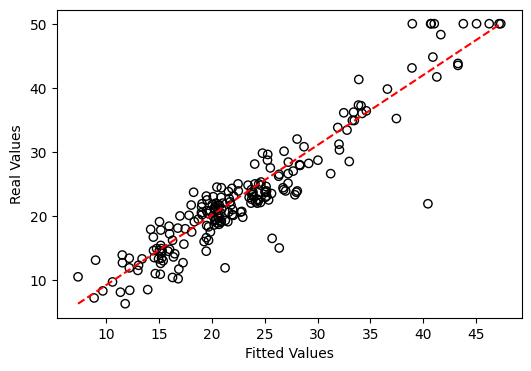

In [38]:
pred = bagger_est.predict(X_test)

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(pred, y_test, facecolor='None', edgecolor='k')
ax.plot([min(pred), max(pred)], [min(y_test), max(y_test)], linestyle='dashed', color='r')

ax.set_xlabel('Fitted Values')
ax.set_ylabel('Real Values')

In [39]:
bagger2 = BaggingRegressor(n_estimators=25, max_features=X_train.shape[1],
                        bootstrap=True, oob_score=True, random_state=1)

bagger_est2 = bagger2.fit(X_train, y_train)

In [40]:
err = np.mean((y_test - bagger_est2.predict(X_test))**2)
print(f'Test set error (when we reduce the number of trees to 25): {err}')

Test set error (when we reduce the number of trees to 25): 13.105214738916255


### Random Forests

In [41]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(n_estimators=500, criterion='squared_error', max_features=6,
                            bootstrap=True, oob_score=True, random_state=1)

regr_fit = regr.fit(X_train, y_train)

In [42]:
# Score of the training dataset obtained using an out-of-bag estimate
regr_fit.oob_score_

0.847914485682647

In [43]:
err = np.mean((y_test - regr_fit.predict(X_test))**2)
print(f'Test set error: {err}')

Test set error: 11.526011596256186


In [44]:
ftr_importances = pd.DataFrame(regr_fit.feature_importances_, columns=['Importance'], index=regr_fit.feature_names_in_)
ftr_importances = ftr_importances.sort_values(axis=0, ascending=False, by='Importance')
ftr_importances

,Importance
lstat,0.406563
rm,0.272510
dis,0.064177
nox,0.059582
crim,0.056821
indus,0.046181
ptratio,0.039115
age,0.025756
tax,0.017348
rad,0.006080


Text(0, 0.5, 'Importance')

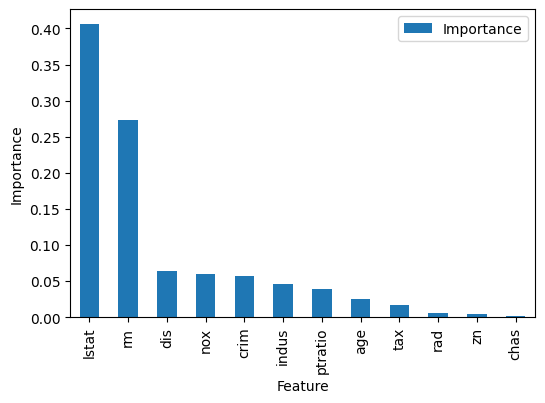

In [45]:
fig, ax = plt.subplots(figsize=(6, 4))
ftr_importances.plot(kind='bar', ax=ax)

ax.set_xlabel('Feature')
ax.set_ylabel('Importance')

The results indicate that across all of the trees considered in the random forest, the wealth of the community (`lstat`) and the house size (`rm`) are by far the two most important variables.

## 8.3.4 Boosting

In [46]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(loss='squared_error', learning_rate=0.001, n_estimators=5000,
                               max_depth=4, random_state=1)

gbr_fit = gbr.fit(X_train, y_train)

In [47]:
ftr_importances = pd.DataFrame(gbr_fit.feature_importances_, columns=['Importance'], index=gbr_fit.feature_names_in_)
ftr_importances = ftr_importances.sort_values(axis=0, ascending=False, by='Importance')
ftr_importances

,Importance
lstat,0.594985
rm,0.232672
dis,0.076321
crim,0.025471
ptratio,0.018573
tax,0.016520
nox,0.015570
age,0.011208
indus,0.004919
rad,0.002629


We see that `lstat` and `rm` are by far the most important variables.

We can also produce partial dependence plots for these two variables. 

- These plots illustrate the marginal effect of the selected variables on the response after integratingouttheothervariables.

- Partial dependence plots (PDPs) are a visual tool used to examine the relationship between a specific predictor variable and the predicted outcome in a machine learning model. PDPs provide insights into the marginal effect of a predictor while keeping other predictors fixed or at their average values.

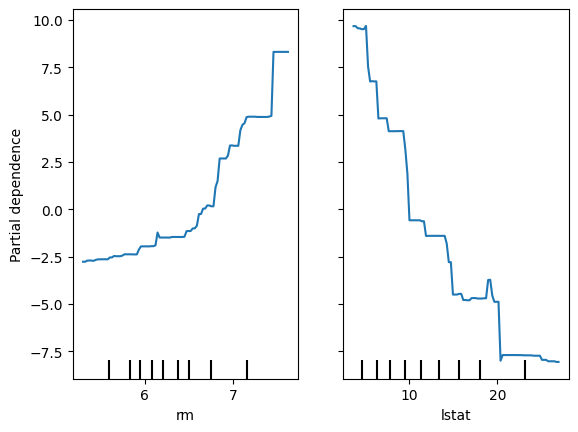

In [48]:
from sklearn.inspection import PartialDependenceDisplay

disp = PartialDependenceDisplay.from_estimator(gbr_fit, X, [5, 11])

In [49]:
err = np.mean((y_test - gbr_fit.predict(X_test))**2)
print(f'Test set error: {err}')

Test set error: 9.736374827592009


This test set error result is superior to the test MSE of random forests and bagging.

In [50]:
# We can change the learning rate, for instance lambda = 0.2

gbr2 = GradientBoostingRegressor(loss='squared_error', learning_rate=0.2, n_estimators=5000,
                               max_depth=4, random_state=1)

gbr_fit2 = gbr2.fit(X_train, y_train)

In [51]:
err = np.mean((y_test - gbr_fit2.predict(X_test))**2)
print(f'Test set error: {err}')

Test set error: 9.28168270711242


In this case, using `λ = 0.2` leads to a lower test MSE than `λ = 0.001`.

## 8.3.5 Bayesian Additive Regression Trees

[TODO] - I couldn't find any way to implement BART with python.